Hough Circle method for detecting center pivot ag. A baseline to compare MaskRCNN against. Working on implementing Stephanie Debat's preprocess code on an example image. Goal is to map circular center pivot and half center pivot cut off due to gridding.

http://scikit-image.org/docs/dev/auto_examples/edges/plot_circular_elliptical_hough_transform.html#sphx-glr-auto-examples-edges-plot-circular-elliptical-hough-transform-py

https://github.com/agroimpacts/cvmlAL/blob/kaixi_branch/pyMappingAfrica/preprocess.py

In [11]:
import matplotlib.pyplot as plt

from skimage import data, color, img_as_ubyte
from skimage.feature import canny, peak_local_max
from skimage.transform import hough_circle, rescale, hough_circle_peaks
from skimage.draw import circle, circle_perimeter
import skimage.io as skio
import numpy as np
from skimage import exposure
from skimage.util import img_as_ubyte
import os

In [1]:
def percentile_rescale(arr):
    '''
    Rescales and applies other exposure functions to improve image vis. 
    http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.rescale_intensity
    '''
    rescaled_arr = np.zeros_like(arr)
    for i in range(0,arr.shape[-1]):
        val_range = (np.percentile(arr[:,:,i], 1), np.percentile(arr[:,:,i], 99))
        rescaled_channel = exposure.rescale_intensity(arr[:,:,i], val_range)
        rescaled_arr[:,:,i] = rescaled_channel
        #rescaled_arr= exposure.adjust_gamma(rescaled_arr, gamma=1) #adjust from 1 either way
#     rescaled_arr= exposure.adjust_sigmoid(rescaled_arr, cutoff=.50) #adjust from .5 either way 
    return rescaled_arr

def convert_image_to_uint8(image):
    """Convert image to uint8 format by normalizing each band
    with I = (D-Dmin)/(Dmax-Dmin)."""
    if image.dtype != 'float':
        image = image.astype('float64')

    if len(image.shape) == 2:
        dmin = image.min()
        dmax = image.max()
        uint8_image = (image - dmin) / (dmax - dmin)

    elif len(image.shape) == 3:
        uint8_image = np.zeros(image.shape)
        for i in range(image.shape[2]):
            dmin = image[:, :, i].min()
            dmax = image[:, :, i].max()
            uint8_image[:, :, i] = (image[:, :, i] - dmin) / (dmax - dmin)

    else:
        print('Error! Image has invalid dimensions for conversion to uint8.')
    
    uint8_image *= 255
    uint8_image = np.around(uint8_image)
    uint8_image = uint8_image.astype('uint8')

    return uint8_image
        
def im_adjust(image, low_percentile, high_percentile):
    """Map intensity values in grayscale image to new values such that X
    percent of data	is saturated at low and high intensities, increasing
    image contrast.
    """
    p1, p2 = np.percentile(image, (low_percentile, high_percentile))
    image_adjusted = exposure.rescale_intensity(image, in_range=(p1, p2))

    return image_adjusted
        
factor = 2
# Load picture, convert to grayscale and detect edges
image_rgb = skio.imread("/home/rave/tana-crunch/waves/cropmask/data/center-pivots/test/410999321/image/410999321.tif")
image_rgb = percentile_rescale(image_rgb)
image_gray = color.rgb2gray(image_rgb)
image_gray = convert_image_to_uint8(image_gray)
image_gray = im_adjust(image_gray, 1, 99)
image_gray = img_as_ubyte(image_gray)
edges = canny(image_gray, sigma=3,
              low_threshold=10, high_threshold=50)
edges = edges.astype('uint8') 
print(edges.shape)
edges = rescale(edges, 1/factor) # Resize output from canny edge detector for faster hough circle detection.
print(edges.shape)
edges = edges.astype('bool')
hough_radii = np.arange(100/factor, 240/factor) # Typical center pivot agriculture radius between 100 and 240 pixels

# Perform a Hough Transform
# The accuracy corresponds to the bin size of a major axis.
# The value is chosen in order to get a single high accumulator.
# The threshold eliminates low accumulators
hough_results = hough_circle(edges, hough_radii, full_output=True)

(1024, 1024)
(512, 512)


/opt/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


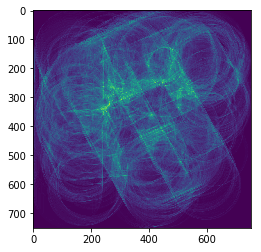

In [5]:
def get_circles_steph_method(img, hough_radii, hough_results, accum_thresh):
    
    centers = []
    accums = []
    radii = []

    for radius, h in zip(hough_radii, hough_results): # For each radius, extract two circles
        
        plt.imshow(h)
        num_peaks = 2
        peaks = peak_local_max(h, num_peaks=num_peaks)
        centers.extend(peaks)
        accums.extend(h[peaks[:, 0], peaks[:, 1]])
        radii.extend([radius] * num_peaks)
    circles = np.zeros(image_gray.shape)

    for idx in np.argsort(accums):
        if accums[idx] > accum_thresh:
            center_x, center_y = centers[idx]
            radius = radii[idx]
            cx, cy = circle(center_y*factor, center_x*factor, radius*factor,
                    shape=img.shape)
            circles[cy, cx] = accums[idx] # float64 0-1

    circles = (circles * 255).astype('uint8')
    return circles
circles = get_circles_steph_method(image_gray, hough_radii,hough_results, .321)

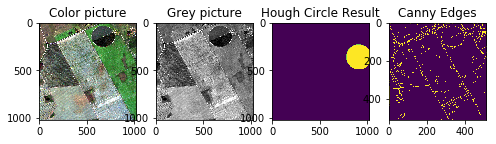

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize=(8, 4),
                                sharex=False, sharey=False)

ax1.set_title('Color picture')
ax1.imshow(image_rgb)

ax2.set_title('Grey picture')
ax2.imshow(image_gray, cmap='gray')

ax3.set_title('Hough Circle Result')
ax3.imshow(circles)

ax4.set_title('Canny Edges')
ax4.imshow(edges)

plt.show()